<a href="https://colab.research.google.com/github/cnyakundi/time-series/blob/master/ACF_and_PACF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACF and PACF

# ACF and PACF
# Autocorrelation Function / Partial Autocorrelation Function
Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.


### Goals
 * Be able to create ACF and PACF charts
 * Create these charts for multiple times series, one with seasonality and another without
 * Be able to calculate Orders PQD terms for ARIMA off these charts (highlight where they cross the x axis)
 
<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html'>stattools.acovf</a></strong><font color=black>(x[, unbiased, demean, fft, …])</font>&nbsp;Autocovariance for 1D<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html'>stattools.acf</a></strong><font color=black>(x[, unbiased, nlags, qstat, …])</font>&nbsp;&nbsp;Autocorrelation function for 1d arrays<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html'>stattools.pacf</a></strong><font color=black>(x[, nlags, method, alpha])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_yw.html'>stattools.pacf_yw</a></strong><font color=black>(x[, nlags, method])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated with non-recursive yule_walker<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_ols.html'>stattools.pacf_ols</a></strong><font color=black>(x[, nlags])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate partial autocorrelations</tt>
   
<h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html'>tsaplots.plot_acf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;Plot the autocorrelation function<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html'>tsaplots.plot_pacf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Plot the partial autocorrelation function</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autocovariance'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Autocovariance</font><br>
<strong>
<a href='https://otexts.com/fpp2/autocorrelation.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autocorrelation</font><br>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm'>NIST Statistics Handbook</a></strong>&nbsp;&nbsp;<font color=black>Partial Autocorrelation Plot</font></div>


## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Load a non-stationary dataset
df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [6]:
# Import the models we'll be using in this section
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

### Ignore harmless warnings
A quick note before we get started. Many of the models used in this and upcoming sections are likely to raise harmless warnings.<br>For instance, the unbiased partial autocorrelation <tt>pacf_yw()</tt> performed below may raise a <tt>RuntimeWarning: invalid value encountered in sqrt</tt>.<br>
We don't really need to be concerned with this, and we can avoid it with the following code

In [7]:
import warnings 

warnings.filterwarnings("ignore")

## Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$


<div class="alert alert-info"><strong>A NOTE ON FORMULA CONVENTIONS:</strong> Different texts employ different symbol conventions. For example, in the above autocovariance formula we use $k$ to represent the amount of lag or shift. Some texts use $h$ instead.</div>


### Autocovariance Example:

### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a <strong>fake</strong> dataset:

In [9]:
df = pd.DataFrame({'a':[13, 5, 11, 12, 9]})
arr = acovf(df['a'])
arr

array([ 8. , -4. , -1.6,  2.2, -0.6])

### Unbiased Autocovariance
Note that the number of terms in the calculations above are decreasing.<br>Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$.

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

In [10]:
arr2 = acovf(df['a'],unbiased=True)
arr2

array([ 8.        , -5.        , -2.66666667,  5.5       , -3.        ])

## Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [11]:
arr3 = acf(df['a'])
arr3

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

## Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [12]:
arr4 = pacf_yw(df['a'],nlags=4,method='mle')
arr4

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

<div class="alert alert-info"><strong>NOTE:</strong> We passed in <tt><font color=black>method='mle'</font></tt> above in order to use biased ACF coefficients. "mle" stands for "maximum likelihood estimation". Alternatively we can pass <tt>method='unbiased'</tt> (the statsmodels default):</div>

In [13]:
arr5 = pacf_yw(df['a'],nlags=4,method='unbiased')
arr5

array([ 1.        , -0.625     , -1.18803419,  2.03764205,  0.8949589 ])

### Partial Autocorrelation with OLS
This provides partial autocorrelations with <a href='https://en.wikipedia.org/wiki/Ordinary_least_squares'>ordinary least squares</a> (OLS) estimates for each lag instead of Yule-Walker.

In [14]:
arr6 = pacf_ols(df['a'],nlags=4)
arr6

array([ 1.        , -0.49677419, -0.43181818,  0.53082621,  0.25434783])

# Plotting
The arrays returned by <tt>.acf(df)</tt> and <tt>.pacf_yw(df)</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. Before we look at plotting arrays, let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. Let's look at the <strong>Airline Passengers</strong> dataset first.

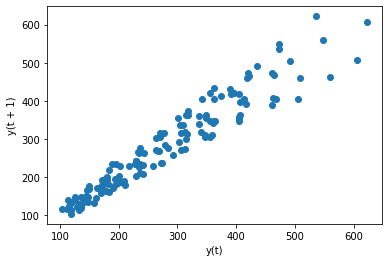

In [16]:
from pandas.plotting import lag_plot
lag_plot(df1['Thousands of Passengers']);

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

Now let's look at the stationary <strong>Daily Total Female Births</strong> dataset:

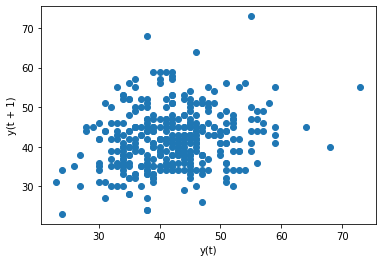

In [17]:
lag_plot(df2['Births']);

As expected, there is little evidence of autocorrelation here.

## ACF Plots
Plotting the magnitude of the autocorrelations over the first few (20-40) lags can say a lot about a time series.

For example, consider the stationary <strong>Daily Total Female Births</strong> dataset:

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [19]:
# Let's look first at the ACF array. By default acf() returns 40 lags
acf(df2['Births'])

array([ 1.        ,  0.21724118,  0.15287758,  0.10821254,  0.09066059,
        0.09595481,  0.09104012,  0.19508071,  0.14115295,  0.06117859,
        0.04781522,  0.04770662, -0.01964707,  0.02287422,  0.08112657,
        0.11185686,  0.07333732,  0.01501845,  0.07270333,  0.06859   ,
        0.09280107,  0.26386846,  0.14012147,  0.06070286,  0.08716232,
        0.05038825,  0.0650489 ,  0.11466565,  0.1552232 ,  0.12850638,
        0.10358981,  0.09734643,  0.04912286,  0.04022798,  0.05838555,
        0.05359812,  0.10151053,  0.08268663,  0.0912185 ,  0.11192192,
        0.05652846])

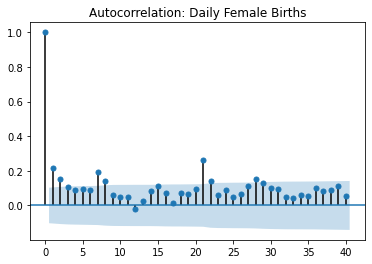

In [20]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Daily Female Births'
lags = 40
plot_acf(df2,title=title,lags=lags);

This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component in the ARIMA model.

Next we'll look at non-stationary data with the <strong>Airline Passengers</strong> dataset:

In [21]:
acf(df1['Thousands of Passengers'])

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092])

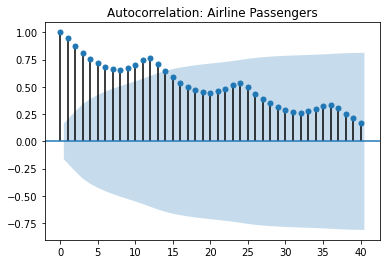

In [22]:
title = 'Autocorrelation: Airline Passengers'
lags = 40
plot_acf(df1,title=title,lags=lags);

This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.

## PACF Plots
Partial autocorrelations work best with stationary data. Let's look first at <strong>Daily Total Female Births</strong>:

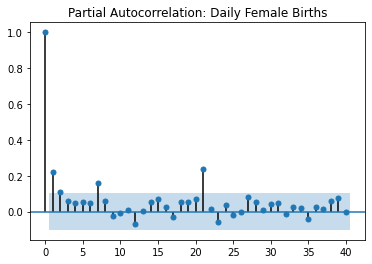

In [23]:
title='Partial Autocorrelation: Daily Female Births'
lags=40
plot_pacf(df2,title=title,lags=lags);

To make the <strong>Airline Passengers</strong> data stationary, we'll first apply <em>differencing</em>:

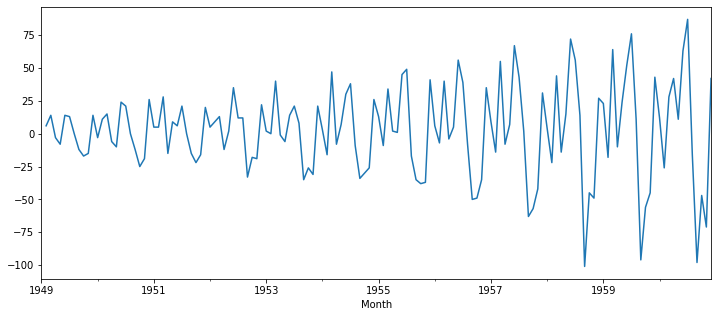

In [24]:
from statsmodels.tsa.statespace.tools import diff

df1['d1'] = diff(df1['Thousands of Passengers'],k_diff=1)
df1['d1'].plot(figsize=(12,5));

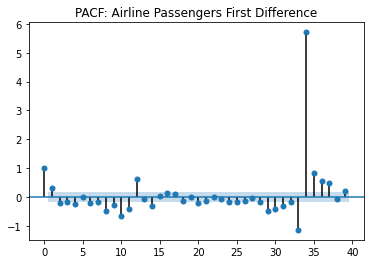

In [25]:
title='PACF: Airline Passengers First Difference'
lags=40
plot_pacf(df1['d1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

### Plot Resizing
In case you want to display the full autocorrelation plot, it helps to increase the figure size using matplotlib:

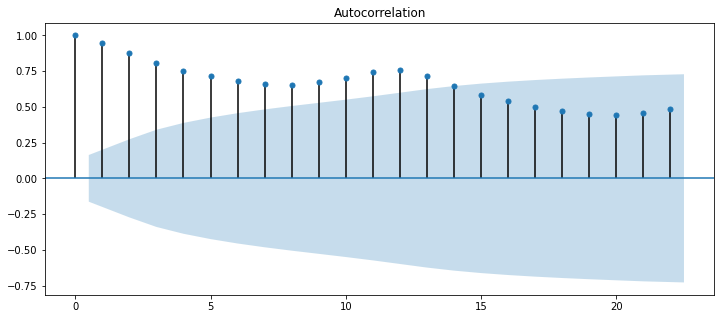

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))

plot_acf(df1['Thousands of Passengers'],ax=ax);

<div class="alert alert-success"><strong>A NOTE ABOUT AUTOCORRELATION:</strong> Some texts compute lagged correlations using the Pearson Correlation Coefficient given by:<br><br>
${\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}$

These are easily calculated in numpy with <tt>numpy.corrcoef(x,y)</tt> and in Excel with <tt>=CORREL(x,y)</tt>.<br><br>
Using our example, $r_0$ is still $1$, but to solve for $r_1$:

${\displaystyle x_1 = [13, 5, 11, 12], \bar{x_1} = 10.25}$<br><br>
$y_1 = [5, 11, 12, 9],\  \bar{y_1} = 9.25$<br><br>
$r_{{x_1}{y_1}}=\frac {(13-10.25)(5-9.25)+(5-10.25)(11-9.25)+(11-10.25)(12-9.25)+(12-10.25)(9-9.25)}
{\sqrt{((13-10.25)^2+(5-10.25)^2+(11-10.25)^2+(12-10.25)^2)}\sqrt{((5-9.25)^2+(11-9.25)^2+(12-9.25)^2+(9-9.25)^2)}} = \frac {-19.25} {33.38} = -0.577$
<br><br>
However, there are some shortcomings. Using the Pearson method, the second-to-last term $r_{k-1}$ will always be $1$ and the last term $r_k$ will always be undefined.
</div>